In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

In [2]:
# Load traffic speed data
df = pd.read_hdf("METR-LA.h5", key="df")

print("Raw data shape:", df.shape)  # (34272, 207)

# Handle missing values
df = df.interpolate().bfill()

Raw data shape: (34272, 207)


In [3]:
with open("adj_METR-LA.pkl", "rb") as f:
    adj_data = pickle.load(f, encoding="latin1")

# Kaggle structure: [sensor_ids, node_id_map, adjacency_matrix]
sensor_ids = adj_data[0]
node_id_map = adj_data[1]
adj_matrix = adj_data[2]

print("Adjacency matrix shape:", adj_matrix.shape)  # (207, 207)

Adjacency matrix shape: (207, 207)


In [4]:
def extract_temporal_features(df):
    features = []

    for sensor in df.columns:
        s = df[sensor]

        features.append([
            sensor,
            s.mean(),
            s.std(),
            s.diff().mean(),
            s.quantile(0.95) - s.quantile(0.05)
        ])

    return pd.DataFrame(
        features,
        columns=[
            "sensor_id",
            "mean_speed",
            "speed_std",
            "avg_change",
            "speed_range"
        ]
    )

temporal_df = extract_temporal_features(df)
print("Temporal feature shape:", temporal_df.shape)

Temporal feature shape: (207, 5)


In [5]:
X = temporal_df.drop(columns=["sensor_id"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

In [6]:
k = 4  # traffic states

kmeans = KMeans(n_clusters=k, random_state=42)
temporal_labels = kmeans.fit_predict(X_scaled)

temporal_df["temporal_cluster"] = temporal_labels

joblib.dump(kmeans, "temporal_kmeans.joblib")

['temporal_kmeans.joblib']

In [7]:
sil = silhouette_score(X_scaled, temporal_labels)
db  = davies_bouldin_score(X_scaled, temporal_labels)

print("Silhouette Score:", round(sil, 4))
print("Davies–Bouldin Index:", round(db, 4))

Silhouette Score: 0.3858
Davies–Bouldin Index: 0.8647


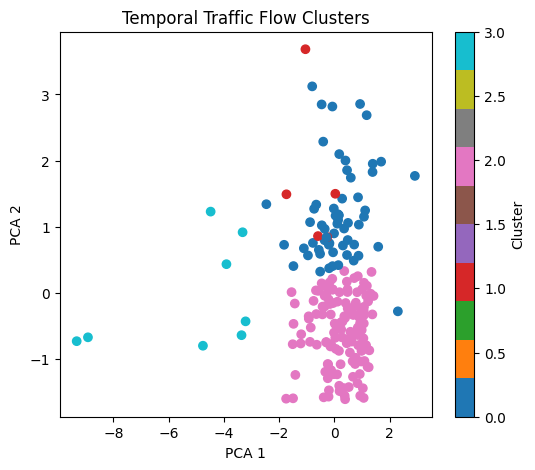

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=temporal_labels, cmap="tab10")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Temporal Traffic Flow Clusters")
plt.colorbar(label="Cluster")
plt.show()

In [9]:
spectral = SpectralClustering(
    n_clusters=k,
    affinity="precomputed",
    assign_labels="kmeans",
    random_state=42
)

spatial_labels = spectral.fit_predict(adj_matrix)

spatial_df = pd.DataFrame({
    "sensor_id": df.columns,
    "spatial_cluster": spatial_labels
})


C:\Users\Sh.Pritpal Singh\Desktop\School Work\extra_gitstuff\SpellChecker\torch_gpu\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:309: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
C:\Users\Sh.Pritpal Singh\Desktop\School Work\extra_gitstuff\SpellChecker\torch_gpu\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [10]:
merged_df = temporal_df.merge(spatial_df, on="sensor_id")

merged_df.head()

,sensor_id,mean_speed,speed_std,avg_change,speed_range,temporal_cluster,spatial_cluster
0,773869,54.631359,22.619199,0.000021,68.444444,0,2
1,767541,60.452789,15.970239,-0.000021,67.714286,2,2
2,767542,60.726120,18.313353,-0.000010,69.375000,2,2
3,717447,49.524287,15.843261,-0.000008,62.888889,2,3
4,717446,46.079798,19.350345,-0.001951,67.666667,1,3


In [11]:
traffic_names = {
    0: "Free-flow",
    1: "Moderate",
    2: "Peak-heavy",
    3: "Unstable"
}

signal_policy = {
    "Free-flow": "Short cycle, equal green splits",
    "Moderate": "Moderate cycle, biased main-road green",
    "Peak-heavy": "Long cycle, dominant-direction priority",
    "Unstable": "Adaptive / responsive signal control"
}

merged_df["traffic_state"] = merged_df["temporal_cluster"].map(traffic_names)
merged_df["signal_strategy"] = merged_df["traffic_state"].map(signal_policy)

merged_df.head()

,sensor_id,mean_speed,speed_std,avg_change,speed_range,temporal_cluster,spatial_cluster,traffic_state,signal_strategy
0,773869,54.631359,22.619199,0.000021,68.444444,0,2,Free-flow,"Short cycle, equal green splits"
1,767541,60.452789,15.970239,-0.000021,67.714286,2,2,Peak-heavy,"Long cycle, dominant-direction priority"
2,767542,60.726120,18.313353,-0.000010,69.375000,2,2,Peak-heavy,"Long cycle, dominant-direction priority"
3,717447,49.524287,15.843261,-0.000008,62.888889,2,3,Peak-heavy,"Long cycle, dominant-direction priority"
4,717446,46.079798,19.350345,-0.001951,67.666667,1,3,Moderate,"Moderate cycle, biased main-road green"


In [12]:
merged_df.to_csv("final_spatiotemporal_clusters.csv", index=False)

print("✅ Training complete")
print("Models + clusters saved")

✅ Training complete
Models + clusters saved
